In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#%cd "/content/drive/My Drive/研究所/論文研究/COVID-19/SEIR"

讀取資料

In [3]:
df = pd.read_excel("Israel-covid19-2020-0221-2022-0228.xlsx", sheet_name = "工作表2")
df.shape

(739, 14)

## 實驗函數

In [4]:
def deriv_1(x, t, alpha, beta, gamma, episilon):
    s, e, i, r, d = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - episilon * e
    didt = episilon * e - (gamma + alpha) * i
    drdt =  gamma * i
    dddt = alpha * i 
    return [dsdt, dedt, didt, drdt, dddt]

In [5]:
# parameter values
R0 = 2.4

total_population = 9291000

# initial number of infected and recovered individuals
i_initial = 1 / total_population
e_initial = np.random.uniform(low=2*i_initial, high=20*i_initial, size=(1)) 
r_initial = 0.0
d_initial = 0.0
s_initial = 1 - e_initial - i_initial - r_initial - d_initial

alpha = np.random.uniform(low=5e-6, high=1e-4, size=(1)) 
beta = np.random.uniform(low=0.05, high=1, size=(1)) 
gamma = np.random.uniform(low=1/9, high=1/4, size=(1)) 
episilon = np.random.uniform(low=1/5.6, high=1/4.8, size=(1)) 


days = len(df)
t = np.linspace(0, days, days)
x_initial = s_initial, e_initial, i_initial, r_initial, d_initial
soln = odeint(deriv_1, x_initial, t, args=(alpha[0], beta[0], gamma[0], episilon[0]))
s, e, i, r, d= soln.T
#print(f's = {s}\ne = {e}\ni = {i}\nr = {r}')
print(f'Random Search')
print(f'Simulated parameters : \nalpha = {alpha}\nbeta = {beta}\ngamma = {gamma}\nepisilon = {episilon}\ne_initial = {e_initial}')
print(f'day : {days}\ns = {s[-1]}, s_p = {s[-1] * total_population}\ne = {e[-1]}, e_p = {e[-1] * total_population}\ni = {i[-1]}, i_p = {i[-1] * total_population}\nr = {r[-1]}, r_p = {r[-1] * total_population}\nd = {d[-1]}, d_p = {d[-1] * total_population}')

Random Search
Simulated parameters : 
alpha = [8.8069185e-06]
beta = [0.16518057]
gamma = [0.12550625]
episilon = [0.19558509]
e_initial = [4.11667481e-07]
day : 739
s = 0.5679663475501268, s_p = 5276975.335088228
e = 0.0007623693427270512, e_p = 7083.173563277032
i = 0.0014208759746728446, i_p = 13201.3586806854
r = 0.42982024614852743, r_p = 3993459.906965968
d = 3.016098394733298e-05, d_p = 280.2257018546707


In [6]:
# Random search for e_initial, alpha, beta, gamma, episilon 
def SEIRD(e_initial, alpha, beta, gamma, episilon):

    R0 = 2.4
    total_population = 9291000  

    i_initial = 1 / total_population
    # e_initial = np.random.uniform(low=2*i_initial, high=20*i_initial, size=(1)) 
    r_initial = 0.0
    d_initial = 0.0
    s_initial = 1 - e_initial - i_initial - r_initial - d_initial

    # alpha = np.random.uniform(low=5e-6, high=1e-4, size=(1)) 
    # beta = np.random.uniform(low=0.05, high=1, size=(1)) 
    # gamma = np.random.uniform(low=1/9, high=1/4, size=(1)) 
    # episilon = np.random.uniform(low=1/5.6, high=1/4.8, size=(1)) 

    days = len(df)
    t = np.linspace(0, days, days)
    x_initial = s_initial, e_initial, i_initial, r_initial, d_initial
    soln = odeint(deriv_1, x_initial, t, args=(alpha, beta, gamma, episilon))
    s, e, i, r, d= soln.T

    return i, r

from sklearn.metrics import mean_squared_error

def RMSE(real_i, real_r, pred_i, pred_r):
    
    RMSE_i = np.sqrt(mean_squared_error(real_i, pred_i))
    RMSE_r = np.sqrt(mean_squared_error(real_r, pred_r))

    return RMSE_i, RMSE_r

def RandomSearch_P(i_initial, len):

    e_initial_lst = np.random.uniform(low=2*i_initial, high=20*i_initial, size=(len)) 

    alpha_lst = np.random.uniform(low=5e-6, high=1e-4, size=(len)) 
    beta_lst = np.random.uniform(low=0.05, high=1, size=(len)) 
    gamma_lst = np.random.uniform(low=1/9, high=1/4, size=(len)) 
    episilon_lst = np.random.uniform(low=1/5.6, high=1/4.8, size=(len)) 

    return e_initial_lst, alpha_lst, beta_lst, gamma_lst, episilon_lst



In [7]:
real_i = np.array(df["total_infectious"])
real_r = np.array(df["total_recovered"])
#real_i


In [8]:
# Random search for 100 times
times = 100
total_population = 9291000 
e_initial_lst, alpha_lst, beta_lst, gamma_lst, episilon_lst = RandomSearch_P(1/total_population, times)

data = {}
for i in range(times):
    
    pred_i, pred_r = SEIRD(e_initial_lst[i], alpha_lst[i], beta_lst[i], gamma_lst[i], episilon_lst[i])
    RMSE_i, RMSE_r = RMSE(real_i, real_r, pred_i * total_population, pred_r * total_population)
    data[i] = {"RMSE_i" : RMSE_i, "RMSE_r" : RMSE_r, "e_initial" : e_initial, "alpha" : alpha, "beta" : beta, "gamma" : gamma, "episilon" : episilon}


In [9]:
data.items()

dict_items([(0, {'RMSE_i': 306437.80727911636, 'RMSE_r': 8068669.763775644, 'e_initial': array([4.11667481e-07]), 'alpha': array([8.8069185e-06]), 'beta': array([0.16518057]), 'gamma': array([0.12550625]), 'episilon': array([0.19558509])}), (1, {'RMSE_i': 294124.41186421027, 'RMSE_r': 6850696.595146729, 'e_initial': array([4.11667481e-07]), 'alpha': array([8.8069185e-06]), 'beta': array([0.16518057]), 'gamma': array([0.12550625]), 'episilon': array([0.19558509])}), (2, {'RMSE_i': 79401.95925262502, 'RMSE_r': 992980.9188960565, 'e_initial': array([4.11667481e-07]), 'alpha': array([8.8069185e-06]), 'beta': array([0.16518057]), 'gamma': array([0.12550625]), 'episilon': array([0.19558509])}), (3, {'RMSE_i': 79051.30808681638, 'RMSE_r': 981033.1681853599, 'e_initial': array([4.11667481e-07]), 'alpha': array([8.8069185e-06]), 'beta': array([0.16518057]), 'gamma': array([0.12550625]), 'episilon': array([0.19558509])}), (4, {'RMSE_i': 79401.96223425229, 'RMSE_r': 992989.2199126474, 'e_initial'

In [10]:
sort_by_RMSE_i = sorted(data.items(), key = lambda x : x[1]["RMSE_i"])
sort_by_RMSE_r = sorted(data.items(), key = lambda x : x[1]["RMSE_r"])
sort_by_RMSE_i_plus_r = sorted(data.items(), key = lambda x : x[1]["RMSE_i"] + x[1]["RMSE_r"])

In [11]:
# 發現基本上這三個算法的排序應該幾乎相同，因此使用["RMSE_i"] + ["RMSE_r"] 做排序
# sort_by_RMSE_i
# sort_by_RMSE_r
sort_by_RMSE_i_plus_r

[(51,
  {'RMSE_i': 63703.38665239536,
   'RMSE_r': 655654.0618520323,
   'e_initial': array([4.11667481e-07]),
   'alpha': array([8.8069185e-06]),
   'beta': array([0.16518057]),
   'gamma': array([0.12550625]),
   'episilon': array([0.19558509])}),
 (50,
  {'RMSE_i': 70451.88869529763,
   'RMSE_r': 675189.2022316707,
   'e_initial': array([4.11667481e-07]),
   'alpha': array([8.8069185e-06]),
   'beta': array([0.16518057]),
   'gamma': array([0.12550625]),
   'episilon': array([0.19558509])}),
 (61,
  {'RMSE_i': 76824.42914816683,
   'RMSE_r': 951641.6548954147,
   'e_initial': array([4.11667481e-07]),
   'alpha': array([8.8069185e-06]),
   'beta': array([0.16518057]),
   'gamma': array([0.12550625]),
   'episilon': array([0.19558509])}),
 (3,
  {'RMSE_i': 79051.30808681638,
   'RMSE_r': 981033.1681853599,
   'e_initial': array([4.11667481e-07]),
   'alpha': array([8.8069185e-06]),
   'beta': array([0.16518057]),
   'gamma': array([0.12550625]),
   'episilon': array([0.19558509])}),
 

In [12]:
total_population = 9291000
9.69116606e-07 * total_population

9.004062386346

#### 實驗結果分析
(81,
  {'RMSE_i': 71225.11478819526,
   'RMSE_r': 743185.2988013381,
   'alpha': array([6.21923485e-05]),
   'beta': array([0.67745532]),
   'e_initial': array([9.69116606e-07]),
   'episilon': array([0.1789692]),
   'gamma': array([0.15300966])})

第81組參數算出最低的RMSE，其參數為:

e_initial = 9.69116606e-07, 乘上total_population後得出9.004062386346，將無條件捨去為9(人)

alpha = 6.21923485e-05

beta = 0.67745532

episilon = 0.1789692

gamma = 0.15300966

### 其他Function

In [13]:
def plotdata(t, s, i, e=None):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, s, lw=3, label='Fraction Susceptible')
    ax[0].plot(t, i, lw=3, label='Fraction Infective')
    ax[0].plot(t, r, lw=3, label='Recovered')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if e is not None: ax[1].plot(t, e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(s, i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()

In [14]:
alpha = np.random.uniform(low=5e-6, high=1e-4, size=(50,)) 
beta = np.random.uniform(low=0.05, high=1, size=(50,)) 
gamma = np.random.uniform(low=1/9, high=1/4, size=(50,)) 
episilon = np.random.uniform(low=1/5.6, high=1/4.8, size=(50,)) 
print(alpha, beta, gamma, episilon)

[5.60684528e-05 7.49168346e-05 2.56767172e-05 5.43743784e-05
 1.16526000e-05 7.48600213e-05 5.06498372e-05 1.95477049e-05
 4.71767578e-05 3.03290028e-05 6.64048052e-05 9.70899478e-05
 1.54412914e-05 5.51542035e-05 8.48873670e-05 8.43220806e-05
 4.15524201e-05 1.49903151e-05 7.53531415e-06 3.61443033e-05
 8.72955004e-05 8.00127977e-05 1.33766797e-05 8.90090652e-05
 2.93044856e-05 9.24482960e-05 6.73623624e-05 6.14880218e-05
 5.29876905e-05 7.08684261e-05 2.55878348e-05 2.21480930e-05
 5.92507753e-05 5.94511418e-06 2.71685601e-05 3.45005679e-05
 3.75205876e-05 7.13710518e-05 6.91630543e-05 6.39229586e-05
 7.08076909e-05 3.60253248e-05 9.22470159e-05 5.20243782e-05
 8.84913173e-05 6.82479163e-06 4.01373060e-05 1.57256979e-05
 7.77853103e-05 7.58079844e-05] [0.99175831 0.94042486 0.43107054 0.93518612 0.96392874 0.98675163
 0.75602425 0.93443673 0.46544836 0.40223718 0.46490793 0.38990056
 0.11170604 0.22850719 0.12424036 0.28094549 0.30325251 0.79114514
 0.08728459 0.10508297 0.31953287 0

day : 7
s = 0.9999997377368814, s_p = 9290997.563313365
e = 1.3836669441159336e-07, e_p = 1.2855649577781139
i = 5.9466379871605025e-08, i_p = 0.5525021353870823
r = 6.443004434662461e-08, r_p = 0.5986195420244893


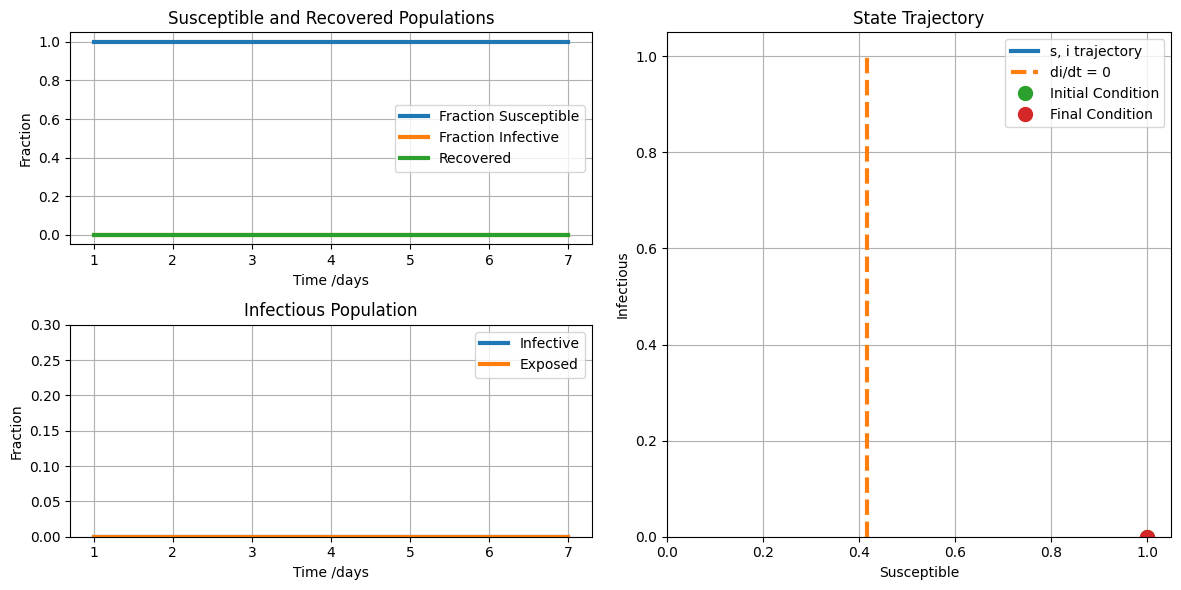

In [15]:
# 最基本的SEIR模型

# parameter values
R0 = 2.4

# Been infected but not contagious to contagious : 5.1 days ; Contagious to Recovered : 3.3 days. 
t_incubation = 5.1
t_infective = 3.3

total_population = 9291000

# initial number of infected and recovered individuals
e_initial = 1/total_population
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

days = 7
t = np.linspace(1, days, days-1)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T
#print(f's = {s}\ne = {e}\ni = {i}\nr = {r}')
print(f'day : {days}\ns = {s[-1]}, s_p = {s[-1] * total_population}\ne = {e[-1]}, e_p = {e[-1] * total_population}\ni = {i[-1]}, i_p = {i[-1] * total_population}\nr = {r[-1]}, r_p = {r[-1] * total_population}')
plotdata(t, s, i, e)

In [17]:
for d in range(1, len(t)+1):
    x_initial = s_initial, e_initial, i_initial, r_initial
    soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
    s, e, i, r = soln.T
    # print(f'day {d} : s = {s[d-1]}, e = {e[d-1]}, i = {i[d-1]}, r = {r[d-1]}')
print(s)

[0.99999989 0.99999988 0.99999986 0.99999983 0.99999978 0.99999974]
